##Fake news detection

In [1]:
##import library 
import pandas as pd
import numpy as np
import re
import math
from flask import jsonify
import graphviz
from nltk.corpus import stopwords
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from graphviz import Digraph
from sklearn.tree import export_graphviz
import pydot
import os

#Data Gathering

In [2]:
df = pd.read_csv("news.csv")
df.head()

,title,text,subject,date,label
0,North Korea says ICBM test used new launch veh...,SEOUL (Reuters) - North Korea said a new inter...,worldnews,29-Nov-17,TRUE
1,WATCH JUDGE ORDER PUNK WEARING “POLICE LIE” T-...,The hate for our law enforcement is at an all ...,politics,18-May-15,FAKE
2,"Biden, Netanyahu discuss Iran, Islamic State, ...",WASHINGTON (Reuters) - U.S. Vice President Joe...,politicsNews,9-Mar-16,TRUE
3,Mansion where Obama to stay in Havana 'built t...,HAVANA (Reuters) - The mansion in Havana where...,politicsNews,18-Mar-16,TRUE
4,"ILLEGAL ALIENS WHO LIED TO COURT, USED FAKE SS...",You can t make this up! Why are these criminal...,left-news,12-Jun-15,FAKE


#Data Anallysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4442 entries, 0 to 4441
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    4442 non-null   object
 1   text     4442 non-null   object
 2   subject  4442 non-null   object
 3   date     4442 non-null   object
 4   label    4442 non-null   object
dtypes: object(5)
memory usage: 173.6+ KB


In [4]:
df['label'].value_counts()

label
TRUE    3050
FAKE    1392
Name: count, dtype: int64

In [5]:
df.shape

(4442, 5)

In [6]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [7]:
df = df.dropna() #Handled Missing values by droping those rows

In [8]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [9]:
df.shape

(4442, 5)

In [10]:
#reset the id (reason in notes)
df.reset_index(inplace=True)
df.head()

,index,title,text,subject,date,label
0,0,North Korea says ICBM test used new launch veh...,SEOUL (Reuters) - North Korea said a new inter...,worldnews,29-Nov-17,TRUE
1,1,WATCH JUDGE ORDER PUNK WEARING “POLICE LIE” T-...,The hate for our law enforcement is at an all ...,politics,18-May-15,FAKE
2,2,"Biden, Netanyahu discuss Iran, Islamic State, ...",WASHINGTON (Reuters) - U.S. Vice President Joe...,politicsNews,9-Mar-16,TRUE
3,3,Mansion where Obama to stay in Havana 'built t...,HAVANA (Reuters) - The mansion in Havana where...,politicsNews,18-Mar-16,TRUE
4,4,"ILLEGAL ALIENS WHO LIED TO COURT, USED FAKE SS...",You can t make this up! Why are these criminal...,left-news,12-Jun-15,FAKE


In [11]:
#removing the unwanted section for date-preprocessing easyness
df = df.drop(['subject','text','date'],axis = 1)
df.head()

,index,title,label
0,0,North Korea says ICBM test used new launch veh...,TRUE
1,1,WATCH JUDGE ORDER PUNK WEARING “POLICE LIE” T-...,FAKE
2,2,"Biden, Netanyahu discuss Iran, Islamic State, ...",TRUE
3,3,Mansion where Obama to stay in Havana 'built t...,TRUE
4,4,"ILLEGAL ALIENS WHO LIED TO COURT, USED FAKE SS...",FAKE


#Data preprocessing

#Step 1: Tokenization

In [12]:
sample_data = 'The quick brown fox jumps over the lazy dog'
sample_data = sample_data.split()
sample_data

['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

#Step 2: Lower Case


In [13]:
sample_data = [data.lower() for data in sample_data]
sample_data

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

In [14]:
#downloading libraries for stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tapen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Step 3: Remove stopwords

In [15]:
stopwords = stopwords.words('english')
print(stopwords[0:10])
print(len(stopwords))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
179


#Step 4: Stemming

In [16]:
ps = PorterStemmer()
sample_data_stemming = [ps.stem(data) for data in sample_data]
print(sample_data_stemming)

['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog']


In [17]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tapen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Step 5: Lamitization

In [18]:
lm = WordNetLemmatizer()
sample_data_lemma = [lm.lemmatize(data) for data in sample_data]
print(sample_data_lemma)

['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazy', 'dog']


#The actual complete preprocessing of the data we have using the title

In [19]:
lm = WordNetLemmatizer()
corpus = []
for i in range (len(df)):
    review = re.sub('^a-zA-Z0-9',' ', df['title'][i]) #re means regualar expression
    review = review.lower()
    review = review.split()
    review = [lm.lemmatize(x) for x in review if x not in stopwords]
    review = " ".join(review)
    corpus.append(review)

#### Testing the preprocessing data



In [20]:
len(corpus) #length 

4442

In [21]:
#initially the title was
df['title'][0]

'North Korea says ICBM test used new launch vehicle, showed successful warhead re-entry'

In [22]:
#After preprocessing we get the same title as
corpus[0]
#here we have removed the words like(we it until) as stopwords changed into lowercase and did lamitization

'north korea say icbm test used new launch vehicle, showed successful warhead re-entry'

#Vectorizatio and classifying the test data

###IDF Function ###
parameters : corpus: set of documents; unique_words : list of sorted unique words

output : dictionary with word as key and its idf value as value


IDF formula :  $IDF(t) = 1+\log_{e}\frac{1\text{ }+\text{ Total  number of documents in collection}} {1+\text{Number of documents with term t in it}}.$




###FIT Function ###
parameters : corpus : set of documents

outputs : vocab: vocabulary dictionary; idf_dict

###Transform function###
parameters : corpus: set of documents, 
             vocab : vocabulary, 
             idf_dict

outputs : normalised sparse matrix

Using L2 Normalisation : document - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html

In [23]:
def idf(corpus,unique_words):
  idf_dict = {}
  total_number_of_documents_in_collection = len(corpus)
  for word in unique_words:
    count = 0
    for sentence in corpus:
      if word in sentence.split(" "):
        count +=1
      idf_dict[word]=(math.log((1+total_number_of_documents_in_collection)/(count+1)))+1
  return idf_dict

class TFIDF:
    def __init__(self):
        self.vocab = None
        self.idf_dict = None

    def fit(self, corpus):
        unique_words = set()
        if isinstance(corpus, (list,)):
            for row in corpus:
                for word in row.split(" "):
                    if len(word) < 2:
                        continue
                    unique_words.add(word)
            unique_words = sorted(list(unique_words))
            self.vocab = {j:i for i, j in enumerate(unique_words)}
            self.idf_dict = idf(corpus, unique_words)
            return self.vocab, self.idf_dict
        else:
            print('Please Pass the list')

    def transform(self, corpus):
        rows = []
        columns = []
        values = []
        if isinstance(corpus, (list,)):
            if self.vocab is None or self.idf_dict is None:
                print("Please fit the model using fit() method before transforming data.")
                return None
            
            for idx, string in enumerate(corpus):
                no_of_terms_in_document = len(string.split(" "))
                for word in string.split(" "):
                    if word in list(self.vocab.keys()):
                        no_of_times_word_in_string = string.split(" ").count(word)
                        tf_idf_values = (no_of_times_word_in_string / no_of_terms_in_document) * self.idf_dict[word]
                        col_index = self.vocab.get(word, -1)
                        if col_index != -1:
                            rows.append(idx)
                            columns.append(col_index)
                            values.append(tf_idf_values)
            output_matrix = csr_matrix((values, (rows, columns)), shape=(len(corpus), len(self.vocab)))
            output_norm_matrix = normalize(output_matrix, norm='l2', axis=1, copy=True, return_norm=False)
            return output_norm_matrix
        else:
            print("Please Pass the list")

In [24]:
tf=TFIDF()
tf.fit(corpus)
x = tf.transform(corpus).toarray()
print(x)
print(type(x))
print(x.shape)
print(x.size)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'>
(4442, 10908)
48453336


In [25]:
y = df['label']
y.head()
y.size

4442

In [26]:
#Data splitting into the train and test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.4, random_state = 11, stratify = y )

In [27]:
len(x_train),len(y_train)

(2665, 2665)

In [28]:
len(x_test), len(y_test)

(1777, 1777)

In [29]:
#print all x_test,x_train, y_train and y_test to see whats going on for more detail
print(x_train)
print(x_test)
print(y_train)
print(y_test)
print(type(x_train))
print(type(y_train))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1125    TRUE
2913    FAKE
2392    TRUE
1869    TRUE
2566    TRUE
        ... 
3105    FAKE
1829    TRUE
180     TRUE
3448    TRUE
2921    TRUE
Name: label, Length: 2665, dtype: object
3841    TRUE
550     TRUE
1828    TRUE
3485    TRUE
515     FAKE
        ... 
486     TRUE
2394    TRUE
2358    FAKE
3238    TRUE
1135    TRUE
Name: label, Length: 1777, dtype: object
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


##### Converting y_train data into array instead of panas.core.series.Series


In [30]:
my_series = pd.Series(y_train)

# Mapping 'TRUE' to 1 and 'FAKE' to 0 using map function
mapped_series = my_series.map({'TRUE': 1, 'FAKE': 0})

# Convert the mapped series to a NumPy array
y_train = mapped_series.to_numpy()

# Display the resulting NumPy array
print(y_train)

[1 0 1 ... 1 1 1]


In [31]:
print (y_train)
print (type(y_train))

[1 0 1 ... 1 1 1]
<class 'numpy.ndarray'>


#Model building


## Decision Tree

In [32]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
    def _gini_index(self, y):
        hist = np.bincount(y)
        probabilities = hist / len(y)
        gini = 1 - np.sum(probabilities ** 2)
        return gini

def visualize_custom_tree(node, depth=0):
    if node is None:
        return

    indent = "    " * depth
    if node.is_leaf_node():
        print(f"{indent}Leaf Node - Value: {node.value}")
    else:
        print(f"{indent}Split on Feature: {node.feature} at Threshold: {node.threshold}")

    visualize_custom_tree(node.left, depth + 1)
    visualize_custom_tree(node.right, depth + 1)

#### Decision tree plot ####

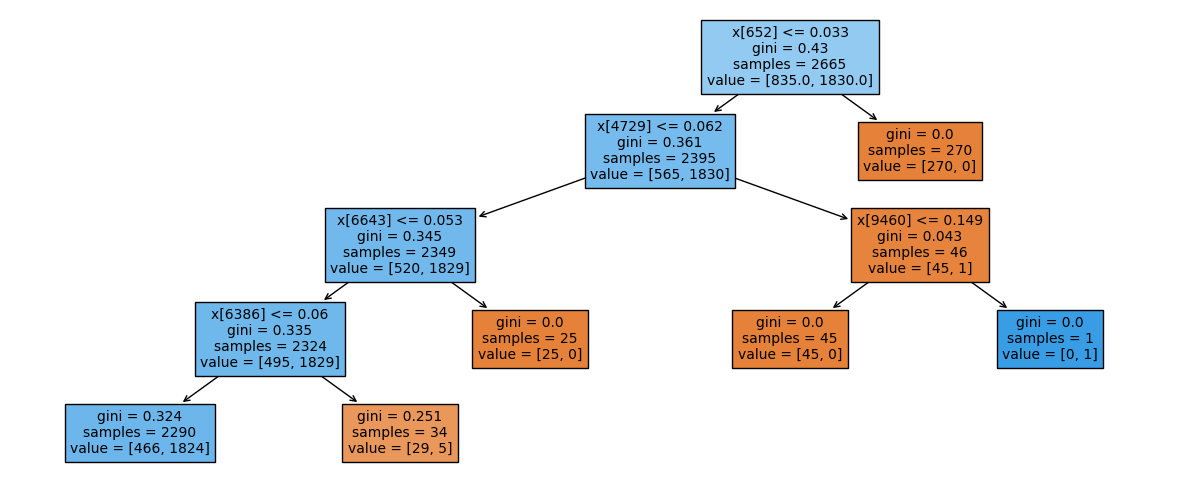

In [33]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
tree=DecisionTreeClassifier(max_depth=4)
X_train=x_train
Y_train=y_train
tree.fit(X_train,Y_train)
plt.figure("Decision Tree",figsize=[12,5])
plot_tree(tree,fontsize=10,filled=True)
plt.tight_layout()

image_folder_path = os.path.join("static", "Images")
# Define the file path for saving the image
image_path = os.path.join(image_folder_path, "decision_tree.png")
# Save the generated image
plt.savefig(image_path)

# Show the plot
plt.show()

## Random Forest

In [34]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

In [35]:
#random forest
rf = RandomForest()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [36]:
#rf=RandomForestClassifier()
#rf.fit(x_train,y_train)

#Model evalation 

In [37]:
my_series = pd.Series(y_test)

# Mapping 'TRUE' to 1 and 'FAKE' to 0 using map function
mapped_series_test = my_series.map({'TRUE': 1, 'FAKE': 0})

# Convert the mapped series to a NumPy array
y_test = mapped_series_test.to_numpy()

# Display the resulting NumPy array
print(y_test)

[1 1 1 ... 0 1 1]


In [38]:
print (y_train)
print (type(y_train))

[1 0 1 ... 1 1 1]
<class 'numpy.ndarray'>


In [39]:
accuracy_score_ = accuracy_score(y_test,y_pred) 
accuracy_score_

0.8266741699493528

In [40]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

class Evaluation:
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        
    def train_evaluation(self):
        y_pred_train = self.model.predict(self.x_train)
        
        acc_scr_train = accuracy_score(self.y_train, y_pred_train)
        print("Accuracy Score On Training Data Set:", acc_scr_train)
        print()
        
        con_mat_train = confusion_matrix(self.y_train, y_pred_train)
        print("Confusion Matrix On Training Data Set:\n", con_mat_train)
        print()
        
        class_rep_train = classification_report(self.y_train, y_pred_train, output_dict=True)
        print("Classification Report On Training Data Set:\n", class_rep_train)
        
        # Define the path to the Images folder
        image_folder = 'static/Images/'

        # Ensure that the Images folder exists
        if not os.path.exists(image_folder):
            os.makedirs(image_folder)

        # Visualize accuracy score using a bar chart
        plt.figure(figsize=(8, 6))
        plt.bar(['Training Accuracy'], [acc_scr_train], color='blue')
        plt.title('Accuracy Score Comparison')
        plt.ylabel('Accuracy Score')
        plt.savefig(image_folder + 'accuracy_bar_chart_train.png')  # Save the plot as an image
        plt.close()  # Close the plot to free up memory

        # Visualize confusion matrix using a heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(con_mat_train, annot=True, cmap='Blues', fmt='d')
        plt.title('Confusion Matrix - Training Data Set')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig(image_folder + 'confusion_matrix_heatmap_train.png')  # Save the plot as an image
        plt.close() 
        
        # Visualize classification report using bar charts for precision, recall, f1-score, and support
        metrics = ['precision', 'recall', 'f1-score', 'support']
        classes = [str(cls) for cls in class_rep_train.keys() if cls.isdigit()]
        plt.figure(figsize=(14, 8))
        for metric in metrics:
            if metric != 'support':
                scores = [class_rep_train[cls][metric] for cls in classes]
                plt.bar(classes, scores, alpha=0.7, label=metric)
            else:
                # Display support as a line plot
                support_scores = [class_rep_train[cls][metric] for cls in classes]
                plt.plot(classes, support_scores, marker='o', linestyle='-', linewidth=2, label=metric)
        plt.title('Classification Report - Training Data Set')
        plt.xlabel('Class')
        plt.ylabel('Score/Support')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(image_folder + 'classification_report_train.png')  # Save the plot as an image
        plt.close()
        
    def test_evaluation(self):
        # Define the path to the Images folder
        image_folder = 'static/Images/'

        y_pred_test = self.model.predict(self.x_test)
        
        acc_scr_test = accuracy_score(self.y_test, y_pred_test)
        print("Accuracy Score On Testing Data Set:", acc_scr_test)
        print()
        
        con_mat_test = confusion_matrix(self.y_test, y_pred_test)
        print("Confusion Matrix On Testing Data Set:\n", con_mat_test)
        print()
        
        class_rep_test = classification_report(self.y_test, y_pred_test, output_dict=True)
        print("Classification Report On Testing Data Set:\n", class_rep_test)
        
        # Visualize accuracy score using a bar chart
        plt.figure(figsize=(8, 6))
        plt.bar(['Testing Accuracy'], [acc_scr_test], color='green')
        plt.title('Accuracy Score Comparison')
        plt.ylabel('Accuracy Score')
        plt.savefig(image_folder + 'accuracy_bar_chart_test.png')  # Save the plot as an image
        plt.close()  # Close the plot to free up memory

        # Visualize confusion matrix using a heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(con_mat_test, annot=True, cmap='Greens', fmt='d')
        plt.title('Confusion Matrix - Testing Data Set')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig(image_folder + 'confusion_matrix_heatmap_test.png')  # Save the plot as an image
        plt.close()
        
        # Visualize classification report using bar charts for precision, recall, f1-score, and support
        metrics = ['precision', 'recall', 'f1-score', 'support']
        classes = [str(cls) for cls in class_rep_test.keys() if cls.isdigit()]
        plt.figure(figsize=(14, 8))
        for metric in metrics:
            if metric != 'support':
                scores = [class_rep_test[cls][metric] for cls in classes]
                plt.bar(classes, scores, alpha=0.7, label=metric)
            else:
                # Display support as a line plot
                support_scores = [class_rep_test[cls][metric] for cls in classes]
                plt.plot(classes, support_scores, marker='o', linestyle='-', linewidth=2, label=metric)
        plt.title('Classification Report - Testing Data Set')
        plt.xlabel('Class')
        plt.ylabel('Score/Support')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(image_folder + 'classification_report_test.png')  # Save the plot as an image
        plt.close()


#### Visualize accuracy ####

In [41]:
Evaluation(rf,x_train, x_test, y_train, y_test).train_evaluation()
Evaluation(rf,x_train, x_test, y_train, y_test).test_evaluation()

Accuracy Score On Training Data Set: 0.8532833020637899

Confusion Matrix On Training Data Set:
 [[ 446  389]
 [   2 1828]]

Classification Report On Training Data Set:
 {'0': {'precision': 0.9955357142857143, 'recall': 0.5341317365269461, 'f1-score': 0.6952455183164459, 'support': 835.0}, '1': {'precision': 0.8245376635092467, 'recall': 0.9989071038251366, 'f1-score': 0.9033852236224363, 'support': 1830.0}, 'accuracy': 0.8532833020637899, 'macro avg': {'precision': 0.9100366888974805, 'recall': 0.7665194201760414, 'f1-score': 0.7993153709694412, 'support': 2665.0}, 'weighted avg': {'precision': 0.8781149139401475, 'recall': 0.8532833020637899, 'f1-score': 0.8381707193333174, 'support': 2665.0}}
Accuracy Score On Testing Data Set: 0.8266741699493528

Confusion Matrix On Testing Data Set:
 [[ 261  296]
 [  12 1208]]

Classification Report On Testing Data Set:
 {'0': {'precision': 0.9560439560439561, 'recall': 0.46858168761220825, 'f1-score': 0.6289156626506024, 'support': 557.0}, '1': {

#Prediction Pipeline

In [42]:
class Preprocessing:
    
    def __init__(self,data):
        self.data = data
        
    def text_preprocessing_user(self):
        lm = WordNetLemmatizer()
        pred_data = [self.data]    
        preprocess_data = []
        for data in pred_data:
            review = re.sub('^a-zA-Z0-9',' ', data)
            review = review.lower()
            review = review.split()
            review = [lm.lemmatize(x) for x in review if x not in stopwords]
            review = " ".join(review)
            preprocess_data.append(review)
        return preprocess_data    

In [43]:
df['title'][1]

'WATCH JUDGE ORDER PUNK WEARING “POLICE LIE” T-SHIRT TO LEAVE COURTROOM…Or Face Contempt Charges'

In [44]:
data = 'WATCH JUDGE ORDER PUNK WEARING “POLICE LIE” T-SHIRT TO LEAVE COURTROOM…Or Face Contempt Charges'
Preprocessing(data).text_preprocessing_user()

['watch judge order punk wearing “police lie” t-shirt leave courtroom…or face contempt charge']

#Prediction 

In [45]:
class Prediction:
    
    def __init__(self,pred_data, model):
        self.pred_data = pred_data
        self.model = model
        
    def prediction_model(self):
        preprocess_data = Preprocessing(self.pred_data).text_preprocessing_user()
        data = tf.transform(preprocess_data).toarray()
        prediction = self.model.predict(data)
        
        if prediction [0] == 1 :
            return "The News headline is -> True"
        
        else:
            return "The News headline is-> Fake"

In [46]:
user_data = 'Biden, Netanyahu discuss Iran, Islamic State, Syria in Jerusalem meeting'
Prediction(user_data,rf).prediction_model()

'The News headline is -> True'

In [47]:
df['title'][11]

'[VIDEO] RINO STRATEGIST KARL ROVE HAS SOLUTION TO GUN VIOLENCE: Repeal Second Amendment'

In [48]:
df.label[11]

'FAKE'

In [49]:
user_data='[VIDEO] RINO STRATEGIST KARL ROVE HAS SOLUTION TO GUN VIOLENCE: Repeal Second Amendment'
Prediction(user_data,rf).prediction_model()

'The News headline is-> Fake'

In [50]:
# import pickle
# filename='finalized_model.pkl'
# pickle.dump(rf,open(filename,'wb'))

In [51]:
# import pickle
# filename='vectorizer.pkl'
# pickle.dump(tf,open(filename,'wb'))